This notebook is the part of the coursework from the Deep Learning School. The aim of this task was to train the GAN model for faces generation

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Part 1. Data preprocessing

As a training sample, we will take a part of the dataset [Flickr Faces](https://github.com/NVlabs/ffhq-dataset) , which contains images of people's faces in high resolution (1024x1024). The original dataset is very large, so we will take a part of it. You can download the dataset [here](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/yarik/Model.pth'

In [ ]:
!ls -l /content/drive/MyDrive/yarik/faces_dataset_small.zip

-rw------- 1 root root 4283591562 Jan  3 13:24 /content/drive/MyDrive/yarik/faces_dataset_small.zip


In [ ]:
! unzip  '/content/drive/MyDrive/yarik/faces_dataset_small.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: faces_dataset_small/00490.png  
  inflating: __MACOSX/faces_dataset_small/._00490.png  
  inflating: faces_dataset_small/01956.png  
  inflating: __MACOSX/faces_dataset_small/._01956.png  
  inflating: faces_dataset_small/02287.png  
  inflating: __MACOSX/faces_dataset_small/._02287.png  
  inflating: faces_dataset_small/01765.png  
  inflating: __MACOSX/faces_dataset_small/._01765.png  
  inflating: faces_dataset_small/03614.png  
  inflating: __MACOSX/faces_dataset_small/._03614.png  
  inflating: faces_dataset_small/03600.png  
  inflating: __MACOSX/faces_dataset_small/._03600.png  
  inflating: faces_dataset_small/01771.png  
  inflating: __MACOSX/faces_dataset_small/._01771.png  
  inflating: faces_dataset_small/04609.png  
  inflating: __MACOSX/faces_dataset_small/._04609.png  
  inflating: faces_dataset_small/01981.png  
  inflating: __MACOSX/faces_dataset_small/._01981.png  
  inflating: faces_data

In [ ]:
!rm -r /content/__MACOSX

In [ ]:
!rm -r /content/faces_dataset_small/04000

In [ ]:
os.mkdir('/content/Images')

In [ ]:
!mv /content/faces_dataset_small /content/Images

In [ ]:
 DATA_DIR = '/content/Images'

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  # TODO: resize images, convert them to tensors and build dataloader
  return train_dl

In [ ]:
image_size = 128
batch_size = 16
train_dl = get_dataloader(image_size, batch_size)
#TODO: build dataloader and transfer it to device

In [ ]:
type(train_dl)

torch.utils.data.dataloader.DataLoader

In [ ]:
data = next(iter(train_dl))

In [ ]:
data[0][0].shape

torch.Size([3, 128, 128])

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Example of images:

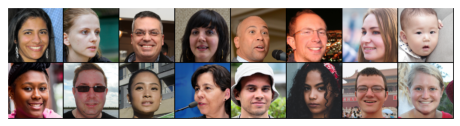

In [ ]:
show_batch(train_dl)


In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Part 2. Model building and training (2 points)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 128, kernel_size=8, stride=4, padding=2, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 400


In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024,512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

torch.Size([16, 3, 128, 128])


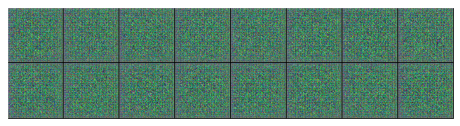

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

Now let's move on to training our GAN. The training algorithm is as follows:
1. Learn the discriminator:
  * take real images and give them the label 1
  * Generate images with the generator and label them as 0
  * Teach the classifier for two classes

2. Teach the generator:
  * generate images with a generator and give them a label of 0
  * Predict with the discriminator whether the image is real or not


We take binary cross-entropy as loss function

In [ ]:
PATH2 = '/content/drive/MyDrive/yarik/'

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(PATH2, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if (epoch + 1)%10 == 0:
          save_samples(epoch+start_idx, fixed_latent, show=False)

         
          plt.figure(figsize=(15, 6))
          plt.plot(losses_d, '-')
          plt.plot(losses_g, '-')
          plt.xlabel('epoch')
          plt.ylabel('loss')
          plt.legend(['Discriminator', 'Generator'])
          plt.title('Losses');

        torch.save({
            'model_discriminator': model["discriminator"].state_dict(),
            'model_generator': model["generator"].state_dict(),
            'optimizerD_state_dict': model["discriminator"].state_dict(),
            'optimizerG_state_dict': model["generator"].state_dict()}, PATH)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}
lr = 0.001
epochs = 110

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/110], loss_g: 2.3235, loss_d: 1.3767, real_score: 0.5834, fake_score: 0.4158


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/110], loss_g: 2.1601, loss_d: 1.3214, real_score: 0.5886, fake_score: 0.4043


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/110], loss_g: 2.2651, loss_d: 1.2734, real_score: 0.5979, fake_score: 0.4008


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/110], loss_g: 2.1981, loss_d: 1.2296, real_score: 0.6045, fake_score: 0.3928


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/110], loss_g: 2.1846, loss_d: 1.2263, real_score: 0.6119, fake_score: 0.3877


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/110], loss_g: 2.3026, loss_d: 1.1771, real_score: 0.6190, fake_score: 0.3758


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/110], loss_g: 2.2509, loss_d: 1.1551, real_score: 0.6285, fake_score: 0.3717


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/110], loss_g: 2.4087, loss_d: 1.1749, real_score: 0.6245, fake_score: 0.3701


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/110], loss_g: 2.1608, loss_d: 1.1582, real_score: 0.6264, fake_score: 0.3748


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/110], loss_g: 2.2430, loss_d: 1.1041, real_score: 0.6387, fake_score: 0.3584
Saving generated-images-0010.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/110], loss_g: 2.4056, loss_d: 1.1455, real_score: 0.6370, fake_score: 0.3610


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/110], loss_g: 2.3255, loss_d: 1.0857, real_score: 0.6501, fake_score: 0.3516


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/110], loss_g: 2.4450, loss_d: 1.0663, real_score: 0.6576, fake_score: 0.3408


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/110], loss_g: 2.6024, loss_d: 1.0217, real_score: 0.6682, fake_score: 0.3298


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/110], loss_g: 2.5042, loss_d: 1.0171, real_score: 0.6778, fake_score: 0.3225


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/110], loss_g: 2.5645, loss_d: 0.9615, real_score: 0.6895, fake_score: 0.3093


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/110], loss_g: 2.7105, loss_d: 0.9431, real_score: 0.6974, fake_score: 0.2985


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/110], loss_g: 2.6774, loss_d: 0.9392, real_score: 0.6985, fake_score: 0.3026


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/110], loss_g: 2.6041, loss_d: 0.9239, real_score: 0.7020, fake_score: 0.2950


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/110], loss_g: 2.7556, loss_d: 0.8598, real_score: 0.7218, fake_score: 0.2801
Saving generated-images-0020.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/110], loss_g: 2.7704, loss_d: 0.8570, real_score: 0.7237, fake_score: 0.2737


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/110], loss_g: 2.7481, loss_d: 0.8488, real_score: 0.7252, fake_score: 0.2735


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/110], loss_g: 2.8746, loss_d: 0.7972, real_score: 0.7411, fake_score: 0.2602


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/110], loss_g: 2.9243, loss_d: 0.7866, real_score: 0.7486, fake_score: 0.2490


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/110], loss_g: 3.0055, loss_d: 0.7285, real_score: 0.7628, fake_score: 0.2378


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/110], loss_g: 3.0027, loss_d: 0.7857, real_score: 0.7532, fake_score: 0.2441


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/110], loss_g: 3.0732, loss_d: 0.6873, real_score: 0.7746, fake_score: 0.2247


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/110], loss_g: 3.2549, loss_d: 0.6761, real_score: 0.7812, fake_score: 0.2199


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/110], loss_g: 3.2316, loss_d: 0.6225, real_score: 0.7954, fake_score: 0.2041


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/110], loss_g: 3.5423, loss_d: 0.5937, real_score: 0.8050, fake_score: 0.1933
Saving generated-images-0030.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/110], loss_g: 3.6962, loss_d: 0.5891, real_score: 0.8101, fake_score: 0.1876


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/110], loss_g: 3.6103, loss_d: 0.5847, real_score: 0.8157, fake_score: 0.1850


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/110], loss_g: 3.7163, loss_d: 0.5010, real_score: 0.8341, fake_score: 0.1649


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/110], loss_g: 3.7798, loss_d: 0.5880, real_score: 0.8185, fake_score: 0.1811


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/110], loss_g: 3.8808, loss_d: 0.5270, real_score: 0.8326, fake_score: 0.1661


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/110], loss_g: 3.9868, loss_d: 0.4827, real_score: 0.8466, fake_score: 0.1521


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/110], loss_g: 4.1519, loss_d: 0.4503, real_score: 0.8552, fake_score: 0.1460


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/110], loss_g: 4.2190, loss_d: 0.3683, real_score: 0.8741, fake_score: 0.1243


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/110], loss_g: 4.5241, loss_d: 0.3870, real_score: 0.8729, fake_score: 0.1260


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/110], loss_g: 4.6650, loss_d: 0.4857, real_score: 0.8567, fake_score: 0.1444
Saving generated-images-0040.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [41/110], loss_g: 4.6299, loss_d: 0.4249, real_score: 0.8666, fake_score: 0.1333


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [42/110], loss_g: 4.6429, loss_d: 0.3395, real_score: 0.8860, fake_score: 0.1124


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [43/110], loss_g: 4.7152, loss_d: 0.3946, real_score: 0.8787, fake_score: 0.1214


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [44/110], loss_g: 4.7674, loss_d: 0.4041, real_score: 0.8772, fake_score: 0.1232


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [45/110], loss_g: 4.6996, loss_d: 0.3405, real_score: 0.8898, fake_score: 0.1099


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [46/110], loss_g: 5.0343, loss_d: 0.2795, real_score: 0.9027, fake_score: 0.0960


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [47/110], loss_g: 5.2627, loss_d: 0.3570, real_score: 0.8922, fake_score: 0.1053


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [48/110], loss_g: 5.0927, loss_d: 0.3374, real_score: 0.8953, fake_score: 0.1070


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [49/110], loss_g: 5.4719, loss_d: 0.3246, real_score: 0.9007, fake_score: 0.0990


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [50/110], loss_g: 5.2749, loss_d: 0.2633, real_score: 0.9145, fake_score: 0.0855
Saving generated-images-0050.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [51/110], loss_g: 5.3374, loss_d: 0.2608, real_score: 0.9145, fake_score: 0.0847


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [52/110], loss_g: 5.6322, loss_d: 0.2286, real_score: 0.9228, fake_score: 0.0772


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [53/110], loss_g: 5.6348, loss_d: 0.2865, real_score: 0.9104, fake_score: 0.0881


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [54/110], loss_g: 5.6087, loss_d: 0.2840, real_score: 0.9157, fake_score: 0.0853


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [55/110], loss_g: 5.8472, loss_d: 0.2166, real_score: 0.9290, fake_score: 0.0701


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [56/110], loss_g: 5.9491, loss_d: 0.3069, real_score: 0.9135, fake_score: 0.0866


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [57/110], loss_g: 6.1351, loss_d: 0.3207, real_score: 0.9056, fake_score: 0.0937


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [58/110], loss_g: 5.8484, loss_d: 0.2462, real_score: 0.9218, fake_score: 0.0781


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [59/110], loss_g: 5.9654, loss_d: 0.1709, real_score: 0.9405, fake_score: 0.0597


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [60/110], loss_g: 6.3343, loss_d: 0.2236, real_score: 0.9301, fake_score: 0.0685
Saving generated-images-0060.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [61/110], loss_g: 6.3425, loss_d: 0.2656, real_score: 0.9241, fake_score: 0.0767


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [62/110], loss_g: 6.1117, loss_d: 0.2518, real_score: 0.9244, fake_score: 0.0755


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [63/110], loss_g: 6.2535, loss_d: 0.2570, real_score: 0.9234, fake_score: 0.0762


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [64/110], loss_g: 6.3192, loss_d: 0.2630, real_score: 0.9257, fake_score: 0.0741


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [65/110], loss_g: 6.2407, loss_d: 0.2207, real_score: 0.9317, fake_score: 0.0680


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [66/110], loss_g: 6.5002, loss_d: 0.1459, real_score: 0.9522, fake_score: 0.0478


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [67/110], loss_g: 6.6300, loss_d: 0.1721, real_score: 0.9429, fake_score: 0.0561


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [68/110], loss_g: 6.9074, loss_d: 0.2007, real_score: 0.9409, fake_score: 0.0613


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [69/110], loss_g: 6.4745, loss_d: 0.2101, real_score: 0.9356, fake_score: 0.0609


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [70/110], loss_g: 6.7863, loss_d: 0.2499, real_score: 0.9290, fake_score: 0.0723
Saving generated-images-0070.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [71/110], loss_g: 6.8412, loss_d: 0.2240, real_score: 0.9322, fake_score: 0.0673


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [72/110], loss_g: 6.6143, loss_d: 0.1896, real_score: 0.9441, fake_score: 0.0567


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [73/110], loss_g: 6.6311, loss_d: 0.1203, real_score: 0.9581, fake_score: 0.0390


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [74/110], loss_g: 6.9505, loss_d: 0.3509, real_score: 0.9149, fake_score: 0.0875


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [75/110], loss_g: 6.6071, loss_d: 0.2292, real_score: 0.9384, fake_score: 0.0620


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [76/110], loss_g: 6.6886, loss_d: 0.1377, real_score: 0.9541, fake_score: 0.0459


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [77/110], loss_g: 6.7906, loss_d: 0.1208, real_score: 0.9589, fake_score: 0.0402


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [78/110], loss_g: 7.1334, loss_d: 0.1183, real_score: 0.9609, fake_score: 0.0386


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [79/110], loss_g: 7.0479, loss_d: 0.1066, real_score: 0.9641, fake_score: 0.0361


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [80/110], loss_g: 7.2383, loss_d: 0.1117, real_score: 0.9621, fake_score: 0.0365
Saving generated-images-0080.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [81/110], loss_g: 7.4721, loss_d: 0.3521, real_score: 0.9165, fake_score: 0.0844


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [82/110], loss_g: 6.9705, loss_d: 0.2090, real_score: 0.9392, fake_score: 0.0604


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [83/110], loss_g: 6.9045, loss_d: 0.0987, real_score: 0.9648, fake_score: 0.0355


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [84/110], loss_g: 7.3047, loss_d: 0.0687, real_score: 0.9740, fake_score: 0.0261


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [85/110], loss_g: 7.6815, loss_d: 0.1828, real_score: 0.9501, fake_score: 0.0487


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [86/110], loss_g: 7.7941, loss_d: 0.2235, real_score: 0.9395, fake_score: 0.0604


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [87/110], loss_g: 7.3011, loss_d: 0.1597, real_score: 0.9534, fake_score: 0.0481


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [88/110], loss_g: 7.3184, loss_d: 0.0880, real_score: 0.9684, fake_score: 0.0303


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [89/110], loss_g: 7.7878, loss_d: 0.0832, real_score: 0.9716, fake_score: 0.0282


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [90/110], loss_g: 8.2631, loss_d: 0.1334, real_score: 0.9598, fake_score: 0.0397
Saving generated-images-0090.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [91/110], loss_g: 7.9723, loss_d: 0.1933, real_score: 0.9493, fake_score: 0.0521


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [92/110], loss_g: 7.7550, loss_d: 0.1226, real_score: 0.9599, fake_score: 0.0389


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [93/110], loss_g: 7.9694, loss_d: 0.0927, real_score: 0.9683, fake_score: 0.0319


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [94/110], loss_g: 8.0203, loss_d: 0.0632, real_score: 0.9765, fake_score: 0.0237


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [95/110], loss_g: 8.5480, loss_d: 0.2859, real_score: 0.9407, fake_score: 0.0600


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [96/110], loss_g: 8.0680, loss_d: 0.1499, real_score: 0.9545, fake_score: 0.0448


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [97/110], loss_g: 8.0263, loss_d: 0.0829, real_score: 0.9715, fake_score: 0.0283


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [98/110], loss_g: 7.9983, loss_d: 0.1281, real_score: 0.9631, fake_score: 0.0364


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [99/110], loss_g: 7.7474, loss_d: 0.1683, real_score: 0.9555, fake_score: 0.0444


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [100/110], loss_g: 8.0198, loss_d: 0.1120, real_score: 0.9641, fake_score: 0.0357
Saving generated-images-0100.png


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [101/110], loss_g: 8.2584, loss_d: 0.1234, real_score: 0.9623, fake_score: 0.0369


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [102/110], loss_g: 8.0702, loss_d: 0.1274, real_score: 0.9632, fake_score: 0.0375


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [103/110], loss_g: 8.2981, loss_d: 0.1575, real_score: 0.9554, fake_score: 0.0451


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [104/110], loss_g: 8.3572, loss_d: 0.1129, real_score: 0.9646, fake_score: 0.0343


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [105/110], loss_g: 8.3611, loss_d: 0.1705, real_score: 0.9571, fake_score: 0.0428


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [106/110], loss_g: 8.3762, loss_d: 0.1115, real_score: 0.9676, fake_score: 0.0310


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [107/110], loss_g: 8.2592, loss_d: 0.1532, real_score: 0.9595, fake_score: 0.0425


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [108/110], loss_g: 8.4650, loss_d: 0.1183, real_score: 0.9655, fake_score: 0.0339


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [109/110], loss_g: 8.2011, loss_d: 0.0914, real_score: 0.9719, fake_score: 0.0283


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [110/110], loss_g: 8.4266, loss_d: 0.0664, real_score: 0.9763, fake_score: 0.0225
Saving generated-images-0110.png


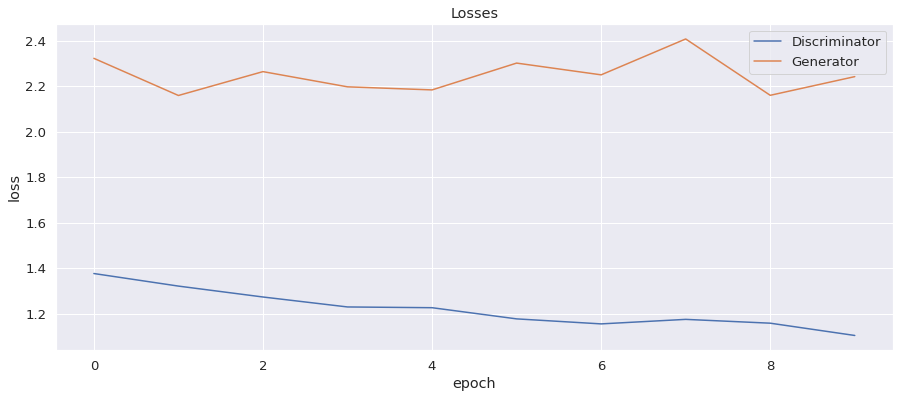

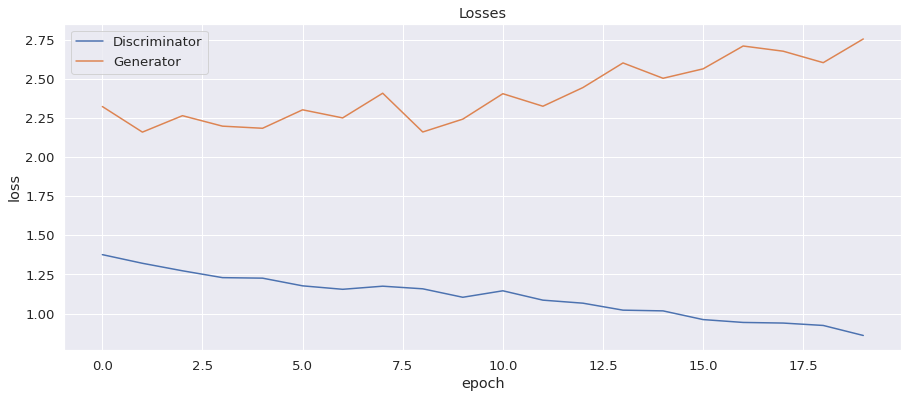

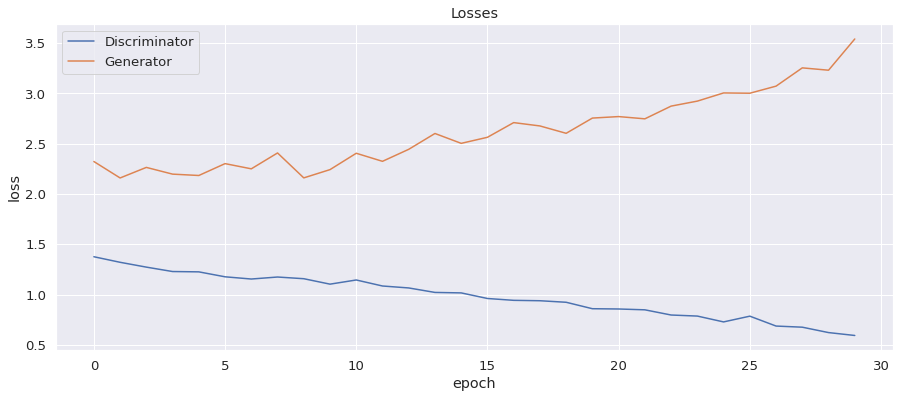

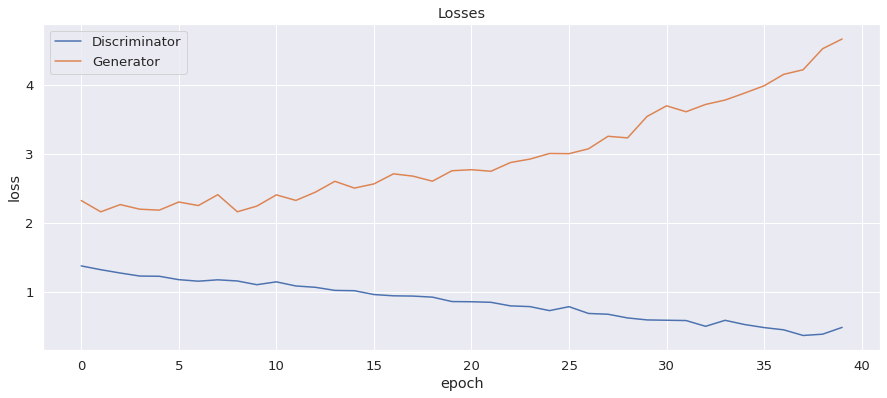

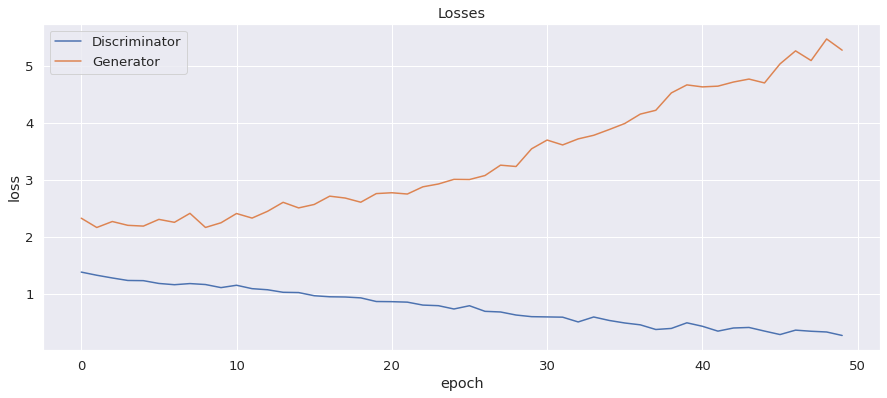

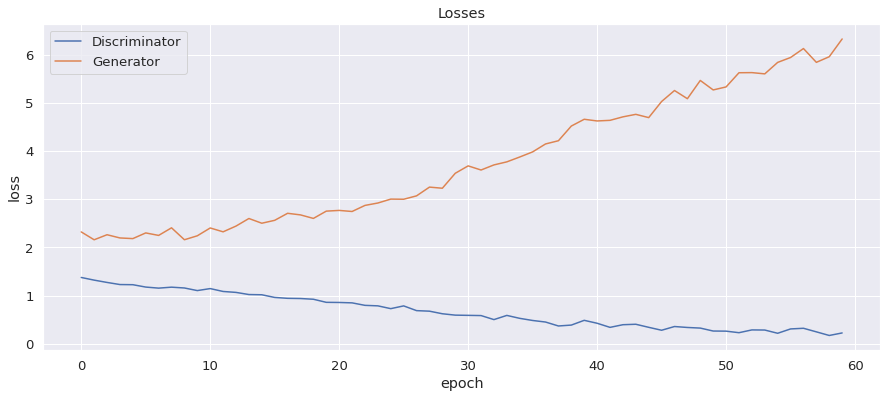

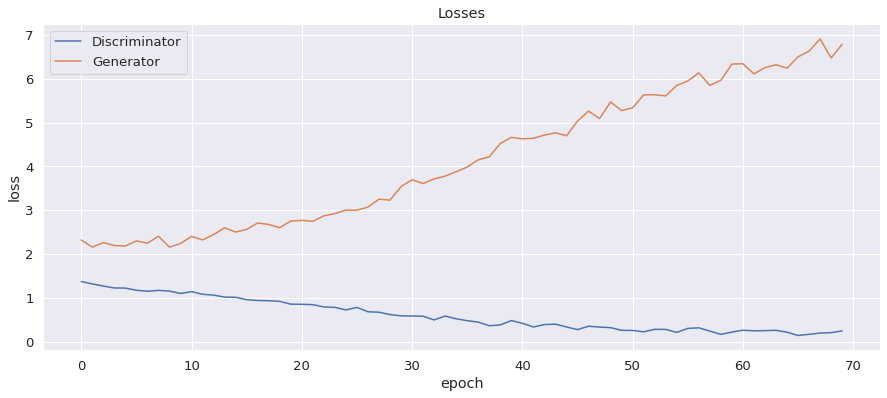

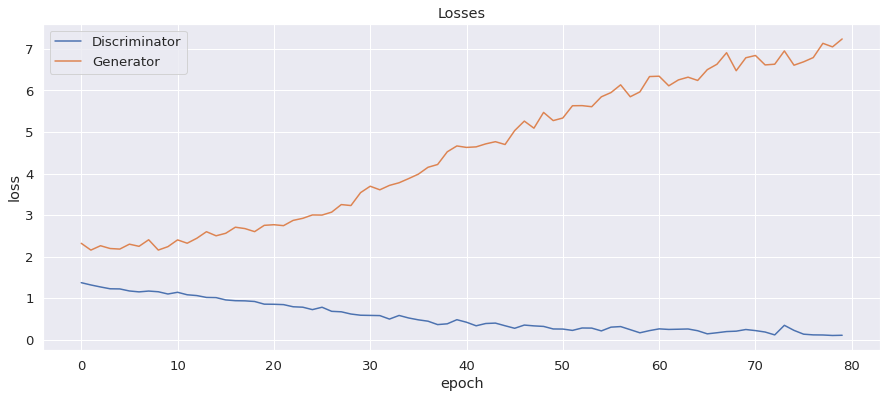

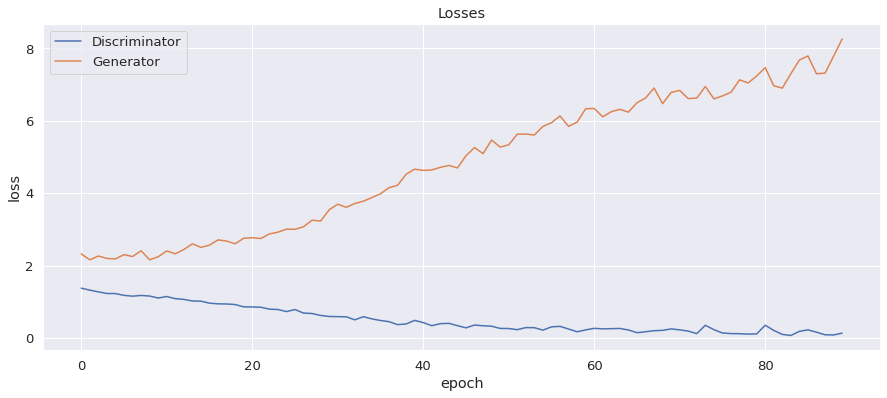

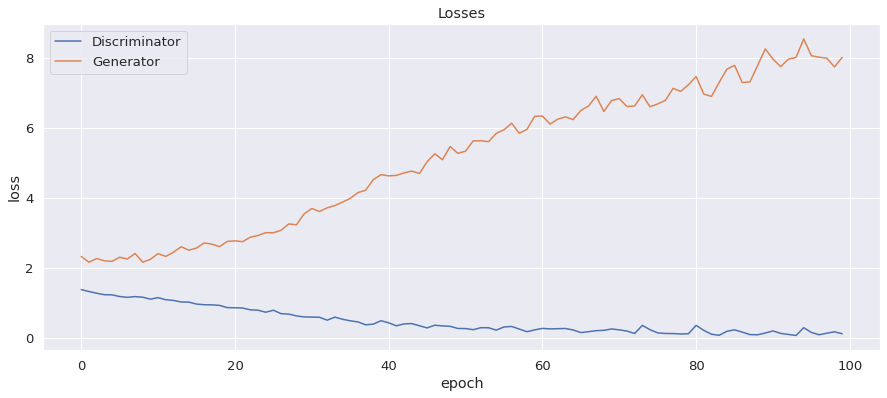

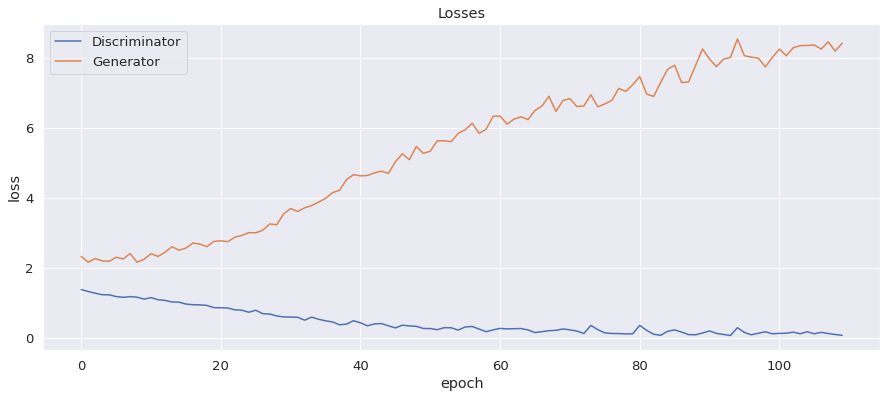

In [ ]:
history = fit(model, criterion, epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

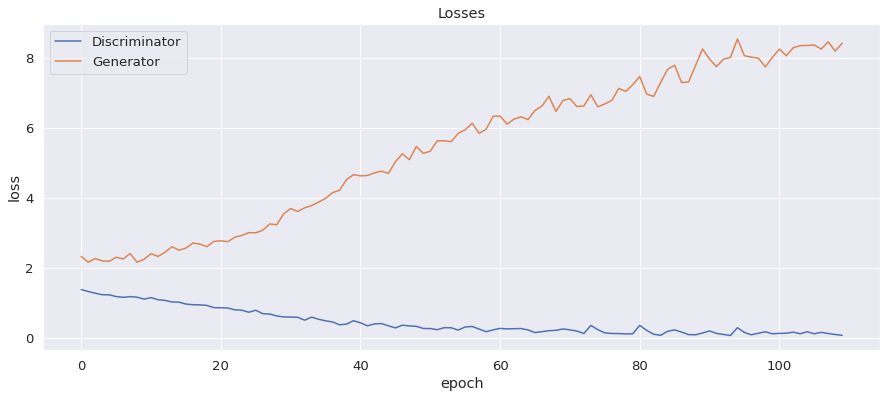

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

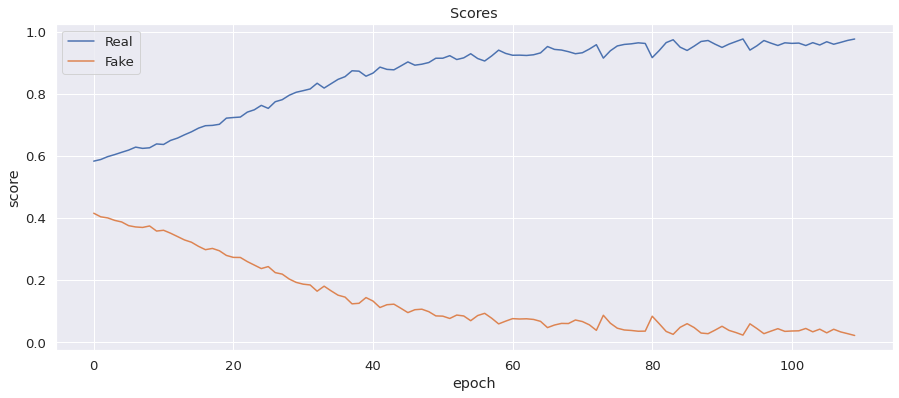

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Part 3. Images generation (1 point)

In [ ]:
generated_img = cv2.imread('/content/drive/MyDrive/gandata/generated-images-0110.png')
generated_img = generated_img[:, :, [2, 1, 0]]

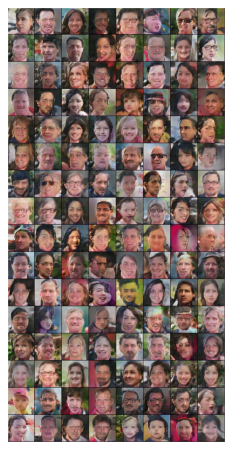

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)